Выполнили **Фадеев Егор** и **Югай Александр**, БЭК181.

In [1]:
!pip install sktime[all_extras]
!pip install matplotlib==3.1.3
!pip install delayed

     |████████████████████████████████| 5.7MB 10.8MB/s 
     |████████████████████████████████| 22.3MB 1.2MB/s 
     |████████████████████████████████| 9.5MB 60.0MB/s 
     |████████████████████████████████| 788kB 60.4MB/s 
     |████████████████████████████████| 102kB 11.7MB/s 
     |████████████████████████████████| 1.5MB 52.2MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 102kB 9.2MB/s 
     |████████████████████████████████| 10.3MB 40.6MB/s 
     |████████████████████████████████| 194kB 78.7MB/s 
     |████████████████████████████████| 1.1MB 48.2MB/s 
     |████████████████████████████████| 716kB 74.3MB/s 
     |████████████████████████████████| 16.9MB 274kB/s 
     |████████████████████████████████| 71kB 9.3MB/s 
     |████████████████████████████████| 

     |████████████████████████████████| 13.1MB 183kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.4.2
    Uninstalling matplotlib-3.4.2:
      Successfully uninstalled matplotlib-3.4.2


     |████████████████████████████████| 81kB 6.2MB/s 
     |████████████████████████████████| 92kB 9.4MB/s 


In [2]:
%matplotlib inline

from IPython import display
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np

from sktime.performance_metrics.forecasting import MeanAbsoluteError

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.ets import AutoETS

from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate

#Временные ряды

##Данные

Выбрали данные по розничным продажам в США в миллионах долларов с 01.1992 по 05.2020 (https://www.kaggle.com/landlord/usa-monthly-retail-trade?select=SeriesReport-Not+Seasonally+Adjusted+Sales+-+Monthly+%28Millions+of+Dollars%29.csv).

In [28]:
#скачаем данные
!wget https://www.dropbox.com/s/seo1brtorupo4gl/SeriesReport-Not%20Seasonally%20Adjusted%20Sales%20-%20Monthly%20%28Millions%20of%20Dollars%29.csv

--2021-06-16 16:09:34--  https://www.dropbox.com/s/seo1brtorupo4gl/SeriesReport-Not%20Seasonally%20Adjusted%20Sales%20-%20Monthly%20%28Millions%20of%20Dollars%29.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6027:18::a27d:4812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/seo1brtorupo4gl/SeriesReport-Not%20Seasonally%20Adjusted%20Sales%20-%20Monthly%20%28Millions%20of%20Dollars%29.csv [following]
--2021-06-16 16:09:35--  https://www.dropbox.com/s/raw/seo1brtorupo4gl/SeriesReport-Not%20Seasonally%20Adjusted%20Sales%20-%20Monthly%20%28Millions%20of%20Dollars%29.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7ab90a5771c2a9e78fdf809822.dl.dropboxusercontent.com/cd/0/inline/BQiU9KJ7kvl6RBjcBmxkNuv7S_P2lcwO6dlxu09ulrCd99uP5CHhwJYDVBQgEX4cSx_bXBT6oj-HA2GdvepXhw1eCNeE9gNhQTCp

In [29]:
#разобьем на выборки
ts = pd.read_csv('SeriesReport-Not Seasonally Adjusted Sales - Monthly (Millions of Dollars).csv', index_col=0)
ts.dropna(inplace=True)
ts.index = pd.PeriodIndex(pd.to_datetime(ts.index, format='%d-%m-%Y') - pd.Timedelta(days=1), freq = 'M')

ts_train = ts[:'2019-04']
ts_test = ts['2019-05':]

In [36]:
ts_train.head()

,Value
Period,
1991-12,146376.0
1992-01,147079.0
1992-02,159336.0
1992-03,163669.0
1992-04,170068.0


In [37]:
ts_test.head()

,Value
Period,
2019-05,518273.0
2019-06,532103.0
2019-07,545247.0
2019-08,496074.0
2019-09,525539.0


##Графики

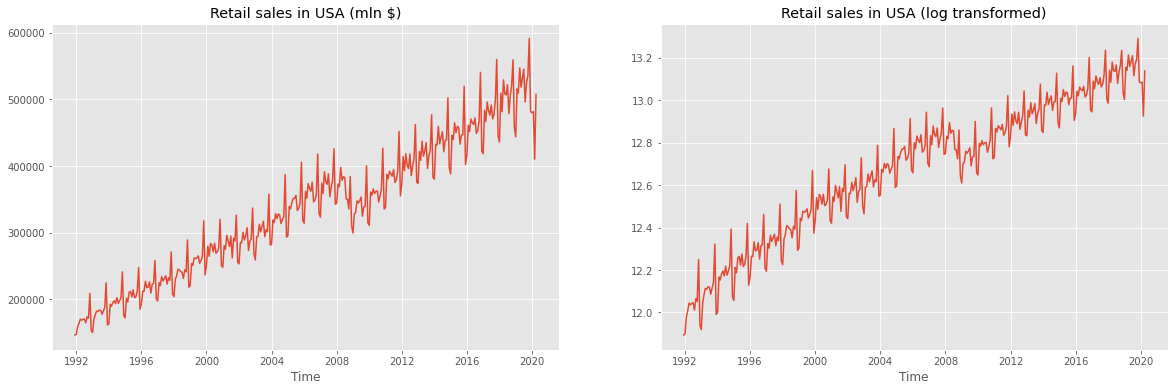

In [38]:
#графики рядов
fig, ax = plt.subplots(1, 2, figsize=(20,6))

ax[0].plot(ts.index.to_timestamp(), ts['Value'])
ax[1].plot(ts.index.to_timestamp(), np.log(ts['Value']))

ax[0].set_xlabel('Time')
ax[0].set_title('Retail sales in USA (mln $)')
ax[1].set_xlabel('Time')
ax[1].set_title('Retail sales in USA (log transformed)');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


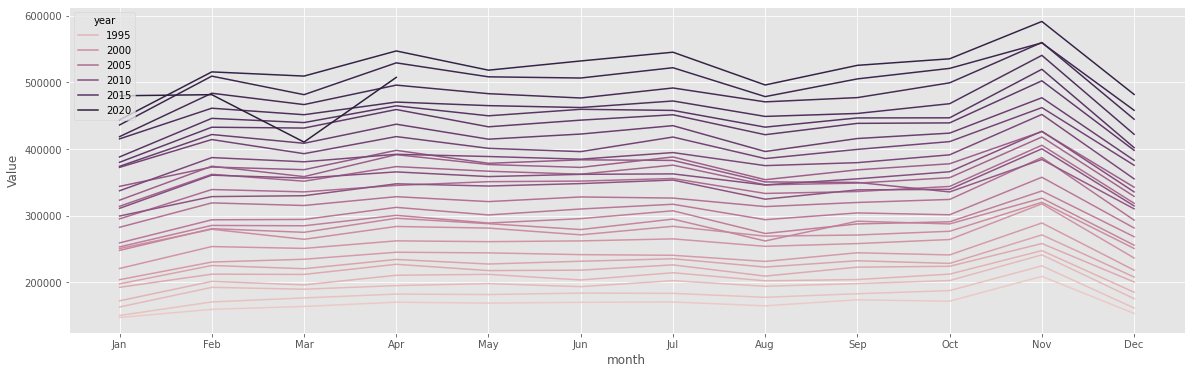

In [39]:
#сезонный график
ts['month'] = ts.index.month
ts['year'] = ts.index.year
fig, ax = plt.subplots(figsize=(20, 6))
sns.lineplot(ts['month'], ts['Value'], hue=ts['year']);
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']);

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


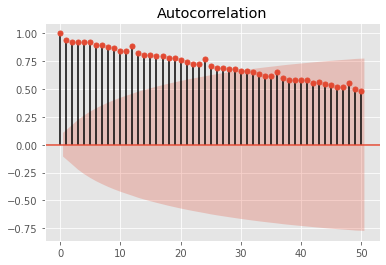

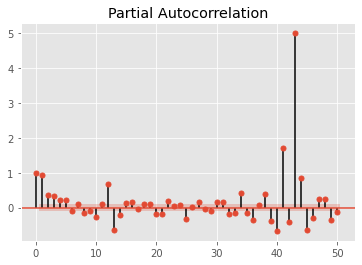

In [40]:
#графики ACF и PACF
plot_acf(ts['Value'], lags=50);
plot_pacf(ts['Value'], lags=50);

**Комментарии:**

1) Ряд обладает сезонностью с периодом, равным 12 (видно по графику ACF и по графику ряда);

2) Явно наблюдается возрастающий тренд объема розничных продаж;

3) Из наличия сезонности и тренда следует нарушение предпосылки о постоянном мат. ожидании ряда, а значит, он не является стационарным;

4) Имеет место небольшое возрастание амплитуды колебаний, начиная с 2015 года;

5) Наблюдается излом графика между 2008 и 2009 годами, возможен излом в 2020 году, но нельзя сказать однозначно, так как ряд обрывается.

##Naive Forecaster

In [41]:
#функция для визуализации результатов
def show_model_pred(ts_train, ts_test, y_pred, model=''):
    plt.figure(figsize=(15, 6))
    plt.plot(ts_train.index.to_timestamp(), ts_train['Value'], label='Train data')
    plt.plot(ts_test.index.to_timestamp(), ts_test['Value'], label='Test data')
    plt.plot(y_pred.to_timestamp().index, y_pred, label='Model prediction', c='g')
    plt.xlabel('Time')
    plt.ylabel('Retail sales in USA (mln $)')
    plt.title(f'{model} prediction')
    plt.legend()
    plt.show()

In [42]:
mae = MeanAbsoluteError()
models = {}

In [43]:
nf = NaiveForecaster(strategy='last')
nf.fit(ts_train['Value'])

fh = ForecastingHorizon(ts_test.index, is_relative=False)
y_pred = nf.predict(fh)

models['Naive forecaster'] = mae(ts_test, y_pred)

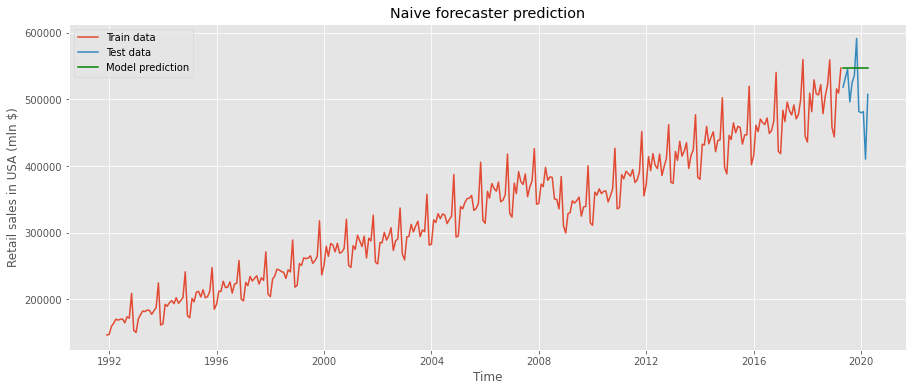

In [44]:
show_model_pred(ts_train, ts_test, y_pred, 'Naive forecaster')

In [45]:
nf_seas = NaiveForecaster(strategy='last', sp=12)
nf_seas.fit(ts_train['Value'])

y_pred = nf_seas.predict(fh)

models['Seasonal naive forecaster'] = mae(ts_test, y_pred)

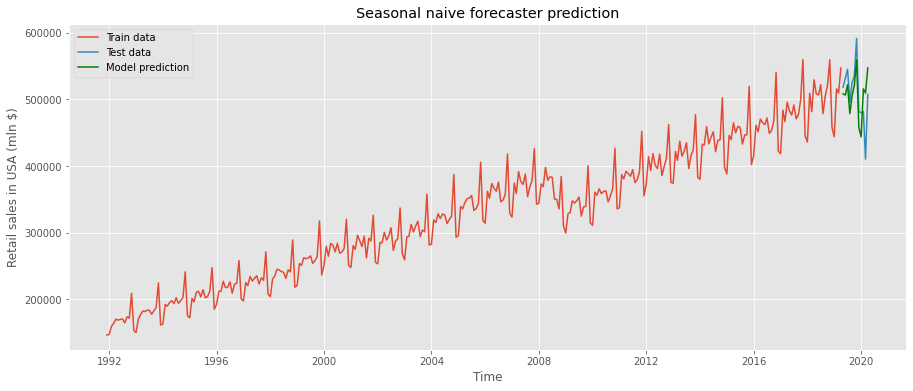

In [46]:
show_model_pred(ts_train, ts_test, y_pred, 'Seasonal naive forecaster')

##SARIMA, AutoSARIMA

Мы использовали SARIMA с немного другими параметрами, поскольку модель с параметрами из условия не работала на наших данных

In [47]:
sarima = ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 0, 12))
sarima.fit(ts_train['Value'])

y_pred = sarima.predict(fh)

models['SARIMA'] = mae(ts_test, y_pred)

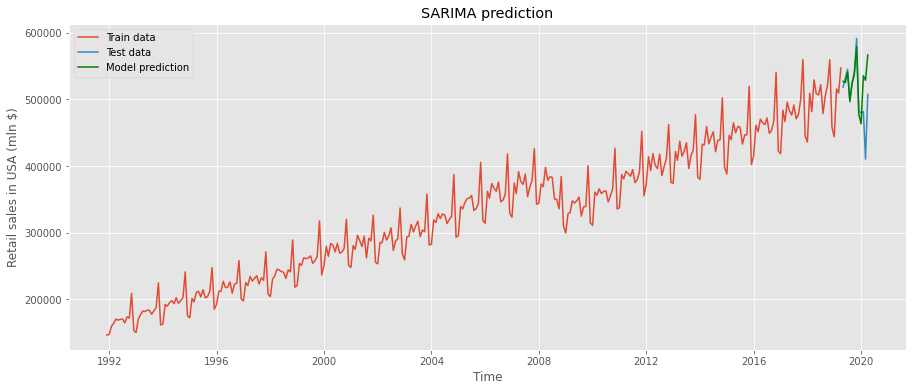

In [48]:
show_model_pred(ts_train, ts_test, y_pred, 'SARIMA')

In [49]:
auto_sarima = AutoARIMA(sp=12)
auto_sarima.fit(ts_train['Value'])

y_pred = auto_sarima.predict(fh)

models['AutoSARIMA'] = mae(ts_test, y_pred)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


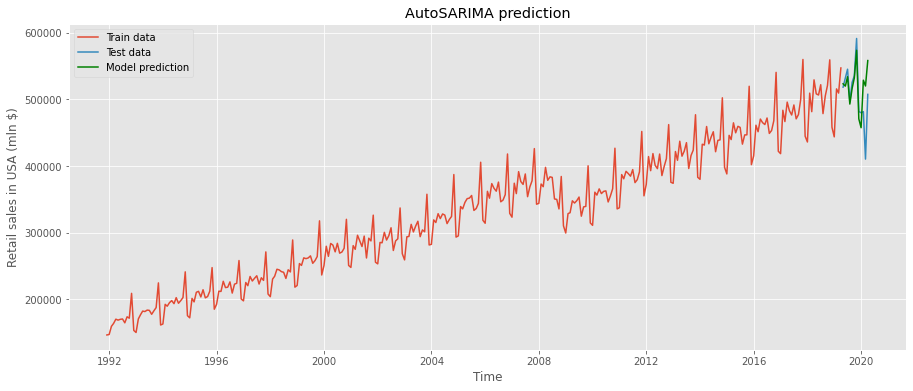

In [50]:
show_model_pred(ts_train, ts_test, y_pred, 'AutoSARIMA')

##ETS, AutoETS

In [51]:
ets = AutoETS(error='add', trend='add', seasonal='add', sp=12)
ets.fit(ts_train['Value'])

y_pred = ets.predict(fh)

models['ETS(AAA)'] = mae(ts_test, y_pred)

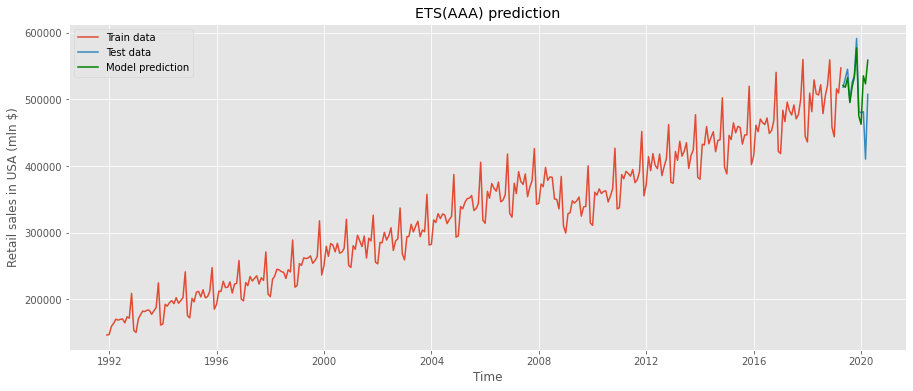

In [52]:
show_model_pred(ts_train, ts_test, y_pred, 'ETS(AAA)')

In [53]:
auto_ets = AutoETS(auto=True, sp=12, allow_multiplicative_trend=True)
auto_ets.fit(ts_train['Value'])

y_pred = auto_ets.predict(fh)

models['AutoETS'] = mae(ts_test, y_pred)

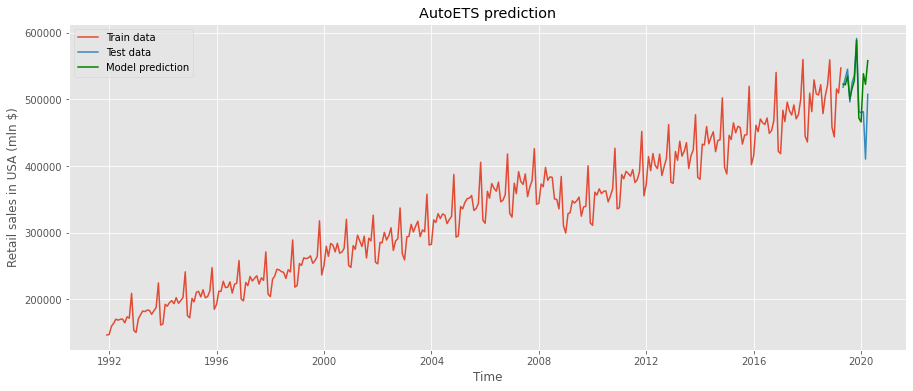

In [54]:
show_model_pred(ts_train, ts_test, y_pred, 'AutoETS')

##Результаты

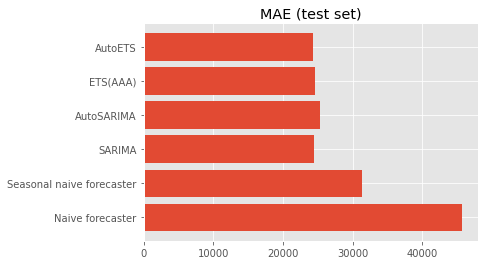

In [55]:
#сравнение метрики для разных моделей
models_name_list, mae_list = list(zip(*models.items()))
plt.barh(models_name_list, mae_list)
plt.title('MAE (test set)');

In [56]:
models

{'AutoETS': 24319.040147264124,
 'AutoSARIMA': 25252.082469913297,
 'ETS(AAA)': 24630.33261872378,
 'Naive forecaster': 45752.25,
 'SARIMA': 24400.12159477352,
 'Seasonal naive forecaster': 31333.416666666668}

Лучшей моделью по итогам оценки на тестовой выборке оказалась AutoETS.

##Кросс-валидация

In [ ]:
window_size = int(ts.shape[0]*0.8)
cv = ExpandingWindowSplitter(fh=1, initial_window=window_size)

models_list = [NaiveForecaster(strategy='last'),
               NaiveForecaster(strategy='last', sp=12),
               ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 0, 12)),
               AutoARIMA(sp=12),
               AutoETS(error='add', trend='add', seasonal='add', sp=12),
               AutoETS(auto=True, sp=12, allow_multiplicative_trend=True)]

models_dict = dict(zip(models_name_list, models_list))

for model in models_dict:
    forecaster = models_dict[model]
    cur_res = evaluate(forecaster, cv, ts['Value'], scoring=mae)

    models[model] = cur_res.iloc[:, -1].mean()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: 

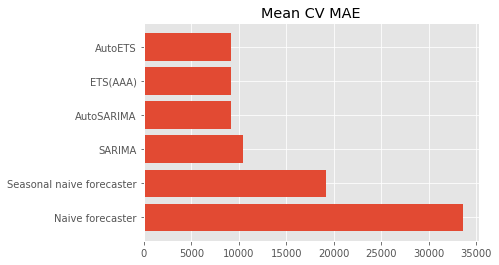

In [ ]:
models_name_list, mae_list = list(zip(*models.items()))
plt.barh(models_name_list, mae_list)
plt.title('Mean CV MAE');

In [ ]:
models

{'AutoETS': 9145.74593502205,
 'AutoSARIMA': 9131.841225720329,
 'ETS(AAA)': 9149.490200754342,
 'Naive forecaster': 33582.59420289855,
 'SARIMA': 24400.12159477352,
 'Seasonal naive forecaster': 19204.028985507248}

По итогам кросс-валидации лучшей моделью оказалась Автоматическая SARIMA, но стоит отметить, что AutoETS и ETS(AAA) дали очень близкий показатель MAE. Предскажем значения на год вперед при помощи AutoSARIMA.

In [57]:
# обучаем на всей выборке
auto_sarima.fit(ts['Value'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978

AutoARIMA(sp=12)

In [58]:
fh_new = ForecastingHorizon(np.arange(1, 13))

In [59]:
y_pred = auto_sarima.predict(fh_new)

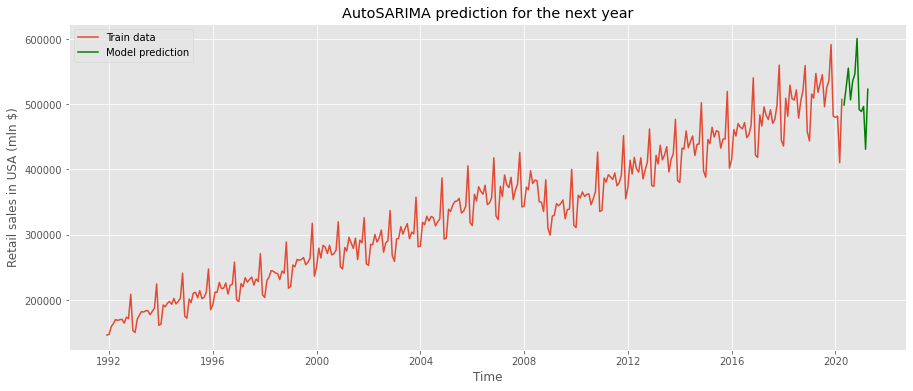

In [60]:
plt.figure(figsize=(15, 6))
plt.plot(ts.index.to_timestamp(), ts['Value'], label='Train data')
plt.plot(y_pred.to_timestamp().index, y_pred, label='Model prediction', c='g')
plt.xlabel('Time')
plt.ylabel('Retail sales in USA (mln $)')
plt.title('AutoSARIMA prediction for the next year')
plt.legend()
plt.show()

#Панельные регрессии

In [3]:
!pip install linearmodels

     |████████████████████████████████| 1.5MB 15.5MB/s 


In [4]:
from linearmodels.panel.model import PanelOLS, RandomEffects, PooledOLS

##Данные и исследовательский вопрос

Выбрали данные по домохозяйствам из RLMS, выгрузили через Stata.

In [5]:
!wget https://www.dropbox.com/s/r3iec5owzmghhcf/pANAL.csv

--2021-06-16 16:00:38--  https://www.dropbox.com/s/r3iec5owzmghhcf/pANAL.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6027:18::a27d:4812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/r3iec5owzmghhcf/pANAL.csv [following]
--2021-06-16 16:00:39--  https://www.dropbox.com/s/raw/r3iec5owzmghhcf/pANAL.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9be0e15c6d89b7d724a9ab9709.dl.dropboxusercontent.com/cd/0/inline/BQg0cqJugY1VEvB51mCGiAJ0t9KfPNAtHrqLSQRwbqUiLNHoN-dTk92JiaiLo4Bzst4TerujXA-ynvRDR6eJ7_9pxf8cnitM980m7ay2EcQDtul3GfsEtF_HRkSSZU6kXP_NNhtq2gwTQWZ-74TWIOn7/file# [following]
--2021-06-16 16:00:39--  https://uc9be0e15c6d89b7d724a9ab9709.dl.dropboxusercontent.com/cd/0/inline/BQg0cqJugY1VEvB51mCGiAJ0t9KfPNAtHrqLSQRwbqUiLNHoN-dTk92JiaiLo4Bzst4TerujXA-ynvRDR6eJ7_9pxf8cnitM

In [6]:
data = pd.read_csv('/content/pANAL.csv')
data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ID_H,ID_W,F14,F14_3
0,1001,1994 год,1500000,NaN
1,1002,1994 год,1329000,NaN
2,1003,1994 год,140000,NaN
3,1004,1994 год,156000,NaN
4,1005,1994 год,670000,NaN


In [7]:
#поменяем формат некоторых столбцов
data['ID_W'] = data['ID_W'].apply(lambda x: x.replace('год', ''))

In [8]:
def str_to_num(x):
  """Converts string to int, if possible"""
  try:
    return int(x)
  except:
    return np.nan

data['F14'] = data['F14'].apply(str_to_num)
data['F14_3'] = data['F14_3'].apply(str_to_num)
data['ID_W'] = data['ID_W'].apply(str_to_num)

data.dropna(inplace=True)
data.head()

,ID_H,ID_W,F14,F14_3
11508,10101,1998,2800.0,1000.0
11515,10201,1998,1200.0,3000.0
11516,10204,1998,500.0,930.0
11517,10205,1998,245.0,162.0
11529,10308,1998,242.0,433.0


Будем исследовать зависимость объема суммарных денежных долгов семьи (переменная F14.3) от суммарного денежного дохода всей семьи за последние 30 дней (переменная F14).

**Исследовательский вопрос:** помогает ли показатель дохода семьи предсказать ее склонность к взятию денег в долг?

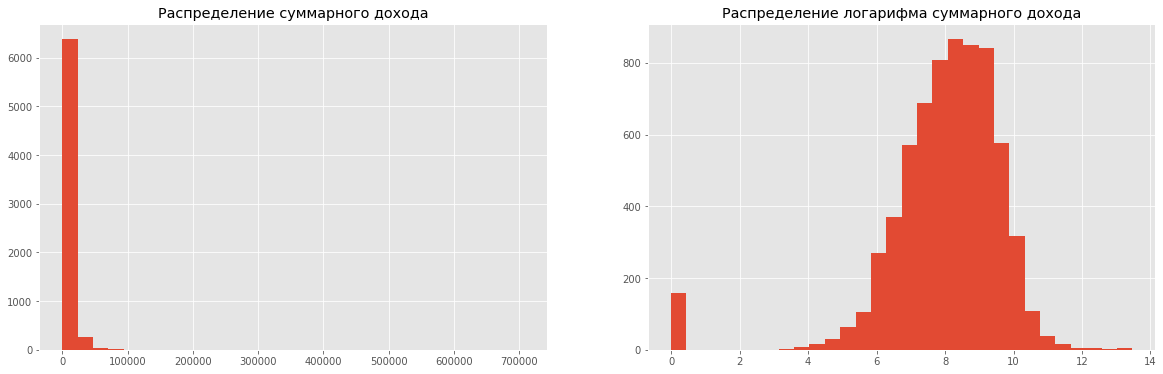

In [9]:
#посмотрим на распределения переменных
fig, ax = plt.subplots(1, 2, figsize=(20,6))

ax[0].hist(data['F14'], bins=30)
ax[1].hist(np.log(1+data['F14']), bins=30)
ax[0].set_title('Распределение суммарного дохода')
ax[1].set_title('Распределение логарифма суммарного дохода');

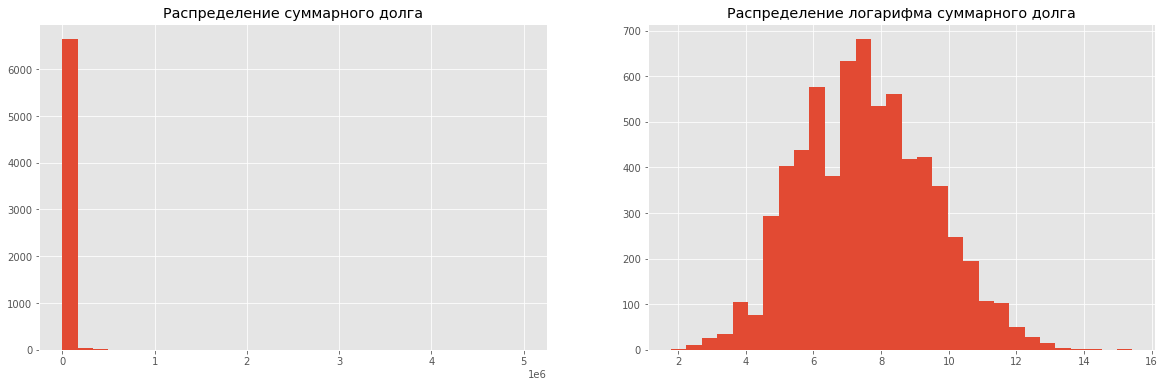

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))

ax[0].hist(data['F14_3'], bins=30)
ax[1].hist(np.log(1+data['F14_3']), bins=30)
ax[0].set_title('Распределение суммарного долга')
ax[1].set_title('Распределение логарифма суммарного долга');

Распределения обеих переменных близки к логнормальным, поэтому применим к ним линейное преобразование.

In [11]:
data['lincome'] = np.log(data['F14'] + 1)
data['ldebts'] = np.log(data['F14_3'] + 1)
data.head()

,ID_H,ID_W,F14,F14_3,lincome,ldebts
11508,10101,1998,2800.0,1000.0,7.937732,6.908755
11515,10201,1998,1200.0,3000.0,7.090910,8.006701
11516,10204,1998,500.0,930.0,6.216606,6.836259
11517,10205,1998,245.0,162.0,5.505332,5.093750
11529,10308,1998,242.0,433.0,5.493061,6.073045


##Визуализация

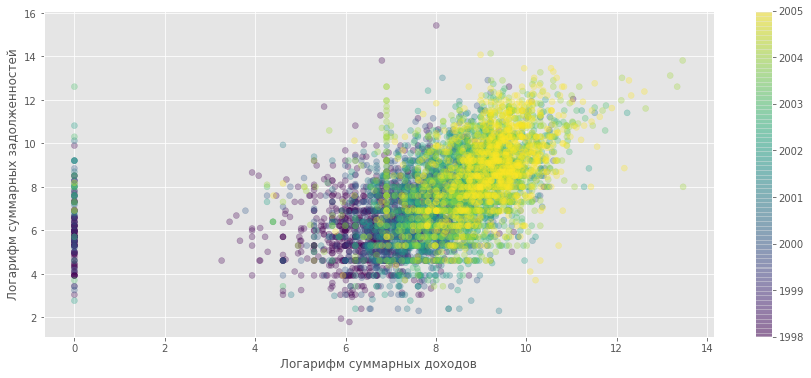

In [12]:
#визуализируем данные
plt.figure(figsize=(15, 6))
plt.xlabel('Логарифм суммарных доходов')
plt.ylabel('Логарифм суммарных задолженностей')
plt.scatter(data['lincome'], data['ldebts'], c=data['ID_W'], alpha=0.3)
plt.colorbar()
plt.show()

По графику видно, что с ростом логарифма доходов семей растет логарифм их задолженностей. Интерпретацию осложняют высокая дисперсия наблюдений и их количество.

##PooledOLS

In [13]:
import statsmodels.api as sm

In [14]:
year = pd.Categorical(data.ID_W)
data = data.set_index(['ID_H', 'ID_W'])

exog_var = 'lincome'
exog = sm.add_constant(data[exog_var])
exog.head()

,,const,lincome
ID_H,ID_W,,
10101,1998,1.0,7.937732
10201,1998,1.0,7.090910
10204,1998,1.0,6.216606
10205,1998,1.0,5.505332
10308,1998,1.0,5.493061


In [15]:
pols = PooledOLS(data.ldebts, exog)

In [16]:
pols_res = pols.fit()

In [17]:
print(pols_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:                 ldebts   R-squared:                        0.2350
Estimator:                  PooledOLS   R-squared (Between):              0.2772
No. Observations:                6712   R-squared (Within):               0.1152
Date:                Wed, Jun 16 2021   R-squared (Overall):              0.2350
Time:                        16:02:30   Log-likelihood                -1.303e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2061.0
Entities:                        3317   P-value                           0.0000
Avg Obs:                       2.0235   Distribution:                  F(1,6710)
Min Obs:                       1.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             2061.0
                            

##Random Effects

In [18]:
re = RandomEffects(data.ldebts, exog)

In [19]:
re_res = re.fit()

In [20]:
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                 ldebts   R-squared:                        0.3408
Estimator:              RandomEffects   R-squared (Between):              0.2724
No. Observations:                6712   R-squared (Within):               0.1267
Date:                Wed, Jun 16 2021   R-squared (Overall):              0.2329
Time:                        16:02:40   Log-likelihood                -1.176e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      3468.8
Entities:                        3317   P-value                           0.0000
Avg Obs:                       2.0235   Distribution:                  F(1,6710)
Min Obs:                       1.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             1749.8
                            

##Fixed Effects

In [21]:
fe = PanelOLS(data.ldebts, exog, entity_effects=True)

In [22]:
fe_res = fe.fit()

In [23]:
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 ldebts   R-squared:                        0.1374
Estimator:                   PanelOLS   R-squared (Between):              0.2460
No. Observations:                6712   R-squared (Within):               0.1374
Date:                Wed, Jun 16 2021   R-squared (Overall):              0.2157
Time:                        16:02:49   Log-likelihood                   -9466.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      540.49
Entities:                        3317   P-value                           0.0000
Avg Obs:                       2.0235   Distribution:                  F(1,3394)
Min Obs:                       1.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             540.49
                            

##Результаты

###Pooled OLS vs Fixed Effects

P-value F-статистики равно 0 (см. таблицу выше), значит, отвергается нулевая гипотеза (PooledOLS лучше FE), следовательно, влияние entity effects значимо и мы отдаем предпочтение модели FE.

###FE vs RE

In [25]:
import numpy.linalg as la
from scipy import stats

#проведем тест Хаусмана на уровне значимости 0.01 (взято отсюда: https://github.com/sglyon/econtools/blob/master/Python/econtools/metrics.py)
def hausman(fe, re):
    """
    Compute hausman test for fixed effects/random effects models
    b = beta_fe
    B = beta_re
    From theory we have that b is always consistent, but B is consistent
    under the alternative hypothesis and efficient under the null.
    The test statistic is computed as
    z = (b - B)' [V_b - v_B^{-1}](b - B)
    The statistic is distributed z \sim \chi^2(k), where k is the number
    of regressors in the model.
    Parameters
    ==========
    fe : statsmodels.regression.linear_panel.PanelLMWithinResults
        The results obtained by using sm.PanelLM with the
        method='within' option.
    re : statsmodels.regression.linear_panel.PanelLMRandomResults
        The results obtained by using sm.PanelLM with the
        method='swar' option.
    Returns
    =======
    chi2 : float
        The test statistic
    df : int
        The number of degrees of freedom for the distribution of the
        test statistic
    pval : float
        The p-value associated with the null hypothesis
    Notes
    =====
    The null hypothesis supports the claim that the random effects
    estimator is "better". If we reject this hypothesis it is the same
    as saying we should be using fixed effects because there are
    systematic differences in the coefficients.
    """

    # Pull data out
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov

    # NOTE: find df. fe should toss time-invariant variables, but it
    #       doesn't. It does return garbage so we use that to filter
    data = b[np.abs(b) < 1e8].size

    # compute test statistic and associated p-value
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B))
    pval = stats.chi2.sf(chi2, data)

    return chi2, data, pval

In [26]:
if hausman(fe_res, re_res)[2] < 0.01:
    print('Нулевая гипотеза отвергается на уровне значимости 0.01')
else:
    print('Нулевая гипотеза не отвергается на уровне значимости 0.01')

Нулевая гипотеза отвергается на уровне значимости 0.01


Нулевая гипотеза отвергается, следовательно, RE несостоятельны, а значит, выбираем FE.

###Итоги

**Выводы:** 

Коэффициенты всех моделей при объясняющих переменных значимы при любом адекватном уровне значимости. В результате проведения тестов было выявлено, что стоит сделать выбор в пользу спецификации FE-модели.

По итогам оценки лучшей модели получаем, что при росте суммарного месячного дохода семьи на 1% суммарные задолженности семьи возрастают на 0.38%. На результаты исследования могли повлиять следующие факторы: omitted variable bias, недостаточное количество наблюдений, нерепрезентатитвность выборки.